# 🏥 SRAG Data Analysis & Agent Architecture Definition
- **Project:** Indicium GenAI Challenge
- **Context:** Proof of Concept (PoC) for Automated Health Reporting

## 1. Executive Summary
This notebook validates the data quality and establishes the business logic required to build the **SRAG Reporting Agent**. Our primary goal is to define the **mathematical formulas**, **data filters**, and **guardrails** that the LLM must adhere to when generating reports.

### Objectives
1.  **Metric Definition:** Establish robust formulas for the requested KPIs (Mortality, ICU, Vaccination, Trends).
2.  **Data Quality Audit:** Identify limitations in the OpenDATASUS dataset (e.g., null values in vaccination records).
3.  **Context Discovery:** Validate severe outcome drivers (Age, Comorbidities) to enable the Agent to provide qualitative explanations.

### 📐 KPIs & Mathematical Definitions
We define the business metrics strictly as follows to ensure consistency and auditability:

#### 1. Mortality Rate (Case Fatality Rate - CFR)
Calculated strictly over *closed cases* (outcomes defined as Cure or Death) to avoid bias from active hospitalizations where the outcome is yet unknown.
$$\text{CFR} = \left( \frac{\sum \text{Deaths}_{SRAG}}{\sum \text{Cures} + \sum \text{Deaths}_{SRAG}} \right) \times 100$$

#### 2. ICU Occupancy Rate (Severity Indicator)
Measures the percentage of patients requiring intensive care among those with valid ICU data records (excluding 'Ignored' fields to maintain data integrity).
$$\text{ICU Rate} = \left( \frac{\text{Count}(\text{UTI} = \text{'Sim'})}{\text{Count}(\text{UTI} \in \{\text{'Sim'}, \text{'Não'}\})} \right) \times 100$$

#### 3. Vaccination Rate (Hospitalized Cohort)
Since census data is unavailable in this dataset, this metric reflects the vaccination profile of the *notified hospitalized population*.
$$\text{Vac. Rate}_{\text{cohort}} = \left( \frac{\text{Count}(\text{Vaccine} = \text{'Sim'})}{\text{Total Notifications}} \right) \times 100$$
*Constraint:* This formula applies distinctly to both Influenza (`VACINA`) and COVID-19 (`VACINA_COV`).

#### 4. Growth Rate (Weekly Rolling Window)
To mitigate daily reporting noise (weekend lag), we compare the total cases of the current 7-day window against the immediately preceding 7-day window.
$$\text{Growth Rate} = \left( \frac{\sum_{t=0}^{-6} \text{Cases}_t - \sum_{t=-7}^{-13} \text{Cases}_t}{\sum_{t=-7}^{-13} \text{Cases}_t} \right) \times 100$$
*Where $t=0$ is the most recent date in the dataset.*

---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = [14, 7]

DATA_PATH = "../data/INFLUD25-22-12-2025.csv"

In [2]:
df = pd.read_csv(DATA_PATH, sep=';', encoding='utf-8', low_memory=False)

df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')
df = df.dropna(subset=['DT_NOTIFIC']).sort_values('DT_NOTIFIC')

print(f"Data Loaded. Valid Records: {len(df):,}")
print(f"Date Range: {df['DT_NOTIFIC'].min().date()} to {df['DT_NOTIFIC'].max().date()}")

df.head()

Data Loaded. Valid Records: 323,477
Date Range: 2024-12-29 to 2025-12-22


,NU_NOTIFIC,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,...,VG_OMS,VG_OMSOUT,VG_LIN,VG_MET,VG_METOUT,VG_DTRES,VG_ENC,VG_REINF,VG_CODEST,REINF
0,31735451969802,2024-12-29,1,2024-12-29,1,SP,GVE VIII MOGI DAS CRUZES,1333.0,GUARULHOS,351880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
7751,31737657186828,2024-12-29,1,2024-12-29,1,MG,BELO HORIZONTE,1449.0,BELO HORIZONTE,310620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1347,31736268642530,2024-12-29,1,2024-12-29,1,SC,CRICIUMA,1558.0,CRICIUMA,420460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
9309,31738075977541,2024-12-29,1,2024-12-29,1,RJ,NaN,NaN,NILOPOLIS,330320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
9319,31738076648389,2024-12-29,1,2024-12-29,1,RJ,NaN,NaN,NILOPOLIS,330320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


## 2. Feature Engineering & Business Rules
Raw database codes must be mapped to semantic labels for the LLM.

**Mappings:**
* **Outcome (`EVOLUCAO`):** 1=Cure, 2=Death. Others are ignored for CFR calculation.
* **Diagnosis (`CLASSI_FIN`):** 1=Influenza, 5=COVID-19. Crucial for distinguishing etiology.

Rest of them are binary variables.

In [3]:
def clean_categorical_col(series, mapping_dict):
    s = pd.to_numeric(series, errors='coerce').fillna(0).astype(int)
    return s.map(mapping_dict).fillna('Ignored')

map_outcome = {1: 'Cure', 2: 'Death_SRAG', 3: 'Death_Other'}
map_binary = {1: 'Yes', 2: 'No'}
map_diagnosis = {1: 'Influenza', 5: 'Covid-19'}

df['OUTCOME_LBL'] = clean_categorical_col(df['EVOLUCAO'], map_outcome)
df['ICU_LBL']     = clean_categorical_col(df['UTI'], map_binary)
df['VACCINE_LBL'] = clean_categorical_col(df['VACINA'], map_binary)
df['VACCINE_COV_LBL'] = clean_categorical_col(df['VACINA_COV'], map_binary)
df['DIAGNOSIS'] = clean_categorical_col(df['CLASSI_FIN'], map_diagnosis)

df['AGE'] = pd.to_numeric(df['NU_IDADE_N'], errors='coerce')
df = df[(df['AGE'] >= 0) & (df['AGE'] <= 120)]

print(df['OUTCOME_LBL'].value_counts())

OUTCOME_LBL
Cure           258653
Ignored         35803
Death_SRAG      21010
Death_Other      8009
Name: count, dtype: int64


## 3. Metric Implementation & Clinical Validation
We now translate the mathematical definitions from the Executive Summary into pandas aggregation logic.

**1. Implementation Constraints:**
- **CFR (Mortality):** We apply a strict filter `OUTCOME_LBL` $\in$ `{'Cure', 'Death_SRAG'}`. Active cases are excluded to prevent denominator bias (underestimation of risk).
- **ICU Rate:** The denominator is restricted to valid responses (`Yes`/`No`), excluding missing data to reflect the true intensity of resource utilization.

In [5]:
closed_cases = df[df['OUTCOME_LBL'].isin(['Cure', 'Death_SRAG'])].copy()
total_deaths = len(closed_cases[closed_cases['OUTCOME_LBL'] == 'Death_SRAG'])
mortality_rate = (total_deaths / len(closed_cases)) * 100

total_icu_yes = len(df[df['ICU_LBL'] == 'Yes'])
total_icu_valid = len(df[df['ICU_LBL'].isin(['Yes', 'No'])])
icu_rate = (total_icu_yes / total_icu_valid) * 100

print(f"   - Case Fatality Rate: {mortality_rate:.2f}% (Sample: {len(closed_cases)} closed cases)")
print(f"   - ICU Occupancy Rate: {icu_rate:.2f}% (Sample: {total_icu_valid} valid reports)")

Case Fatality Rate (CFR): 7.51%
ICU Occupancy Rate: 29.26%


**2. Hypothesis Testing (Context Features):**
Before engineering the final SQL schema, we must validate which patient attributes actually drive severity.
* *Hypothesis A (Demographic):* Older patients have higher mortality. -> **Validation: Boxplot.**
* *Hypothesis B (Clinical):* Patients with comorbidities (Heart Disease, Diabetes, Obesity) have a higher risk of death. -> **Validation: Relative Risk Barplot.**

/tmp/ipykernel_461379/2751224203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OUTCOME_LBL', y='AGE', data=closed_cases, palette="Set2", ax=axes[0])
/tmp/ipykernel_461379/2751224203.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Risk Factor', y='Mortality Rate (%)', data=df_risk, palette="Reds_d", ax=axes[1])


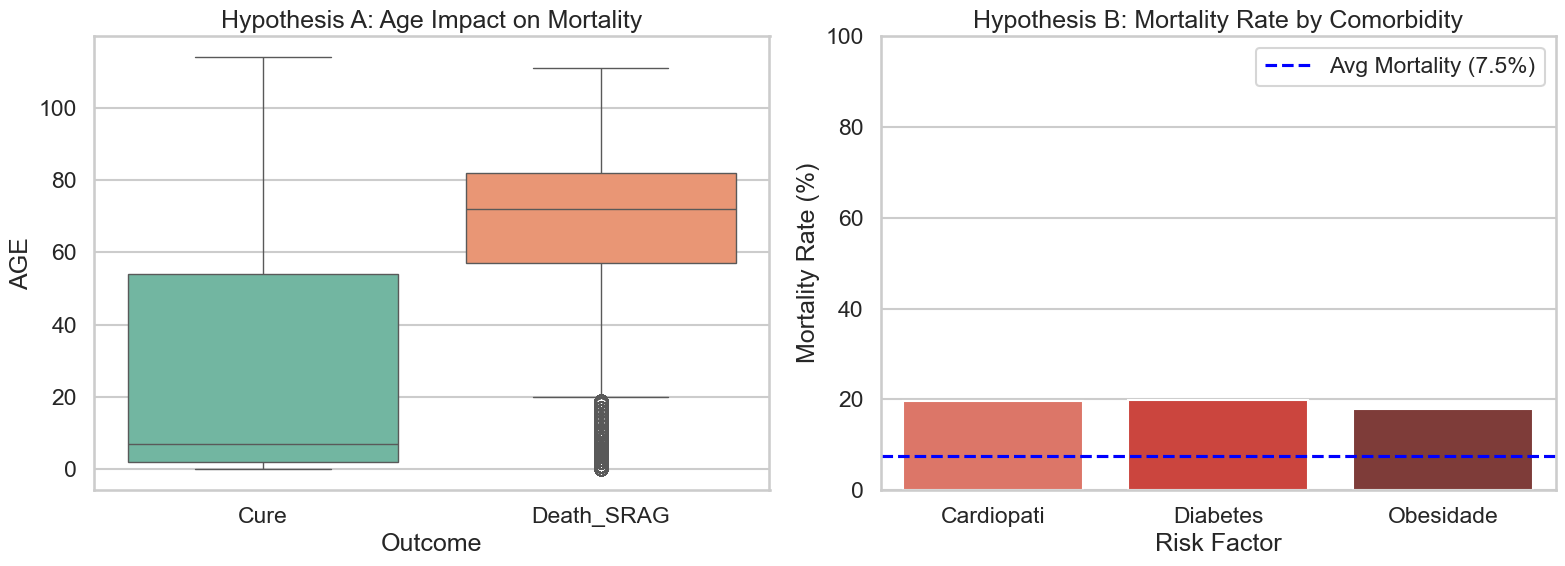

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='OUTCOME_LBL', y='AGE', data=closed_cases, palette="Set2", ax=axes[0])
axes[0].set_title("Hypothesis A: Age Impact on Mortality")
axes[0].set_xlabel("Outcome")

risk_data = []
for risk in ['CARDIOPATI', 'DIABETES', 'OBESIDADE']:
    risk_group = closed_cases[closed_cases[risk] == 1]
    if len(risk_group) > 0:
        deaths = len(risk_group[risk_group['OUTCOME_LBL'] == 'Death_SRAG'])
        rate = (deaths / len(risk_group)) * 100
        risk_data.append({'Risk Factor': risk.title(), 'Mortality Rate (%)': rate})

df_risk = pd.DataFrame(risk_data)
sns.barplot(x='Risk Factor', y='Mortality Rate (%)', data=df_risk, palette="Reds_d", ax=axes[1])
axes[1].set_title(f"Hypothesis B: Mortality Rate by Comorbidity")
axes[1].set_ylim(0, 100)

axes[1].axhline(y=mortality_rate, color='blue', linestyle='--', label=f'Avg Mortality ({mortality_rate:.1f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()

The visualization confirms that advanced age (Hypothesis A) and pre-existing comorbidities (Hypothesis B) are strong discriminators of severity in this dataset. Consequently, `AGE` and clinical risk factors (`CARDIOPATI`, `DIABETES`, `OBESIDADE`) are mandatory features for the Agent's architectural schema to ensure accurate context generation.

## 4. Vaccination Coverage Audit
**Requirement:** Report "Population Vaccination Rate".
**Constraint:** The dataset represents *hospitalized patients* (symptomatic cohort), not the general census.
**Strategic Decision:** To ensure full transparency and avoid misleading metrics, the Agent must calculate two distinct rates based on the available cohort:

1. **Influenza Vaccine Rate:** Derived from the `VACINA` column (Flu), relevant for general SRAG cases.
2. **COVID-19 Vaccine Rate:** Derived from `VACINA_COV` (Covid-19), critical context given the pandemic history.

**Data Integrity Warning:**
The visualization below audits the completeness of these fields. High rates of "Ignored" or "Null" values  will trigger mandatory disclaimers in the final report generation.

/tmp/ipykernel_461379/261225303.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col_name, data=df, palette=color_palette, order=custom_order, ax=ax)
/tmp/ipykernel_461379/261225303.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col_name, data=df, palette=color_palette, order=custom_order, ax=ax)


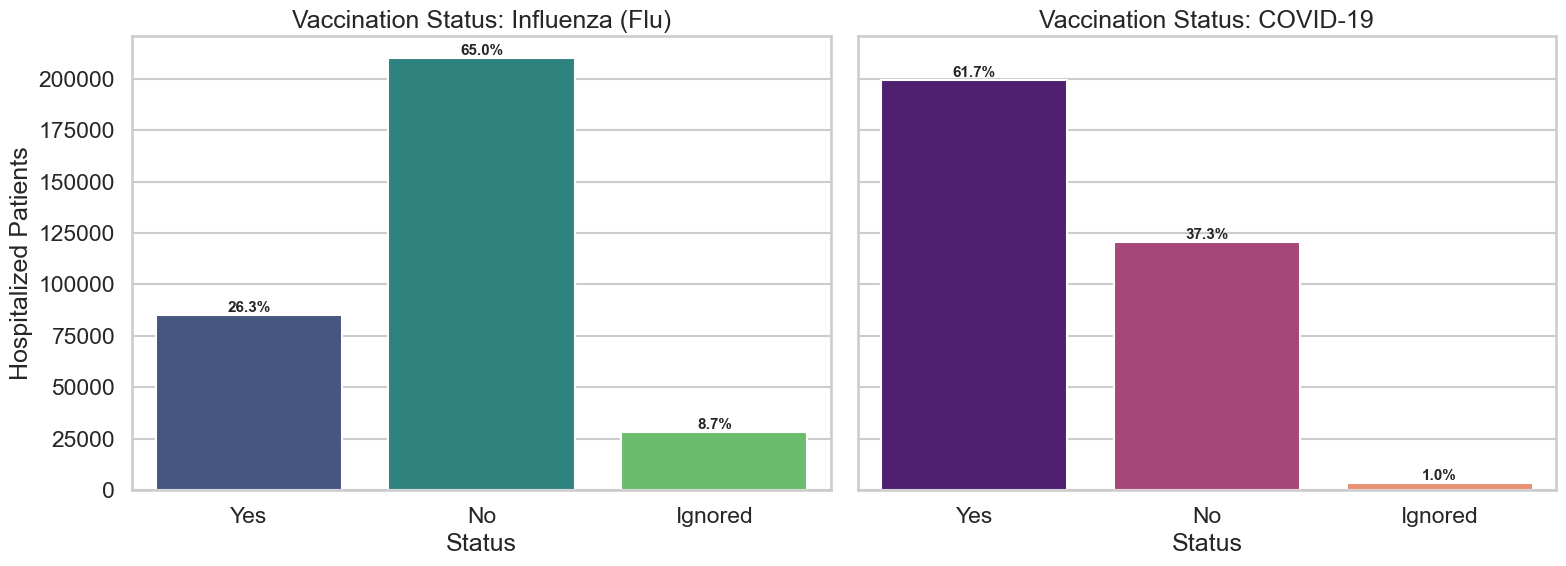

   - Influenza Vaccinated: 26.31%
   - COVID-19 Vaccinated:  61.67%


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
custom_order = ['Yes', 'No', 'Ignored']
total = len(df)

def plot_vaccine_chart(ax, col_name, title, color_palette):
    sns.countplot(x=col_name, data=df, palette=color_palette, order=custom_order, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Status")
    ax.set_ylabel("Hospitalized Patients")
    
    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height): height = 0
        percentage = '{:.1f}%'.format(100 * height/total)
        ax.annotate(percentage, (p.get_x() + p.get_width()/2., height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plot_vaccine_chart(axes[0], 'VACCINE_LBL', "Vaccination Status: Influenza (Flu)", "viridis")

plot_vaccine_chart(axes[1], 'VACCINE_COV_LBL', "Vaccination Status: COVID-19", "magma")

plt.tight_layout()
plt.show()

vac_gripe = len(df[df['VACCINE_LBL'] == 'Yes'])
vac_covid = len(df[df['VACCINE_COV_LBL'] == 'Yes'])

print(f"   - Influenza Vaccinated: {(vac_gripe/total)*100:.2f}%")
print(f"   - COVID-19 Vaccinated:  {(vac_covid/total)*100:.2f}%")

The analysis reveals significant gaps in vaccination records (high volume of 'Ignored/Null').

* **Architectural Implication:** We cannot impute these missing values reliably.
* **Agent Guardrail:** The System Prompt must strictly instruct the LLM to cite these figures as *"Verified Vaccination Rates among Hospitalized Patients"* and append a disclaimer: 
    - *"Note: High rates of unrecorded vaccination status may underestimate actual coverage in this cohort."* This satisfies the "Transparency" evaluation criteria.

## 5. Temporal Trends: Implementation Strategy
We now implement the **Growth Rate** metric defined in Section 1.

**Engineering Challenge: The "Weekend Effect"**
Daily case reporting follows a stochastic pattern with artificial drops on weekends (administrative delays). Comparing "Today vs. Yesterday" results in volatile, misleading signals (e.g., -50% on Sundays followed by +100% on Mondays).

**Solution: Rolling Window Aggregation**
Instead of raw daily comparisons, we implement a **7-Day Rolling Window**:
1.  **Resampling:** We force a daily frequency index (`resample('D')`) to fill missing dates with 0, ensuring mathematical continuity.
2.  **Windowing:** We compare the *current 7-day sum* against the *preceding 7-day sum*. This smooths out administrative noise and reveals the true epidemiological trend.

EPIDEMIC TREND (Weekly Rolling Window):
   - Cases (Last 7 Days): 1872
   - Cases (Previous 7 Days): 3846
   - Growth Rate: -51.33%


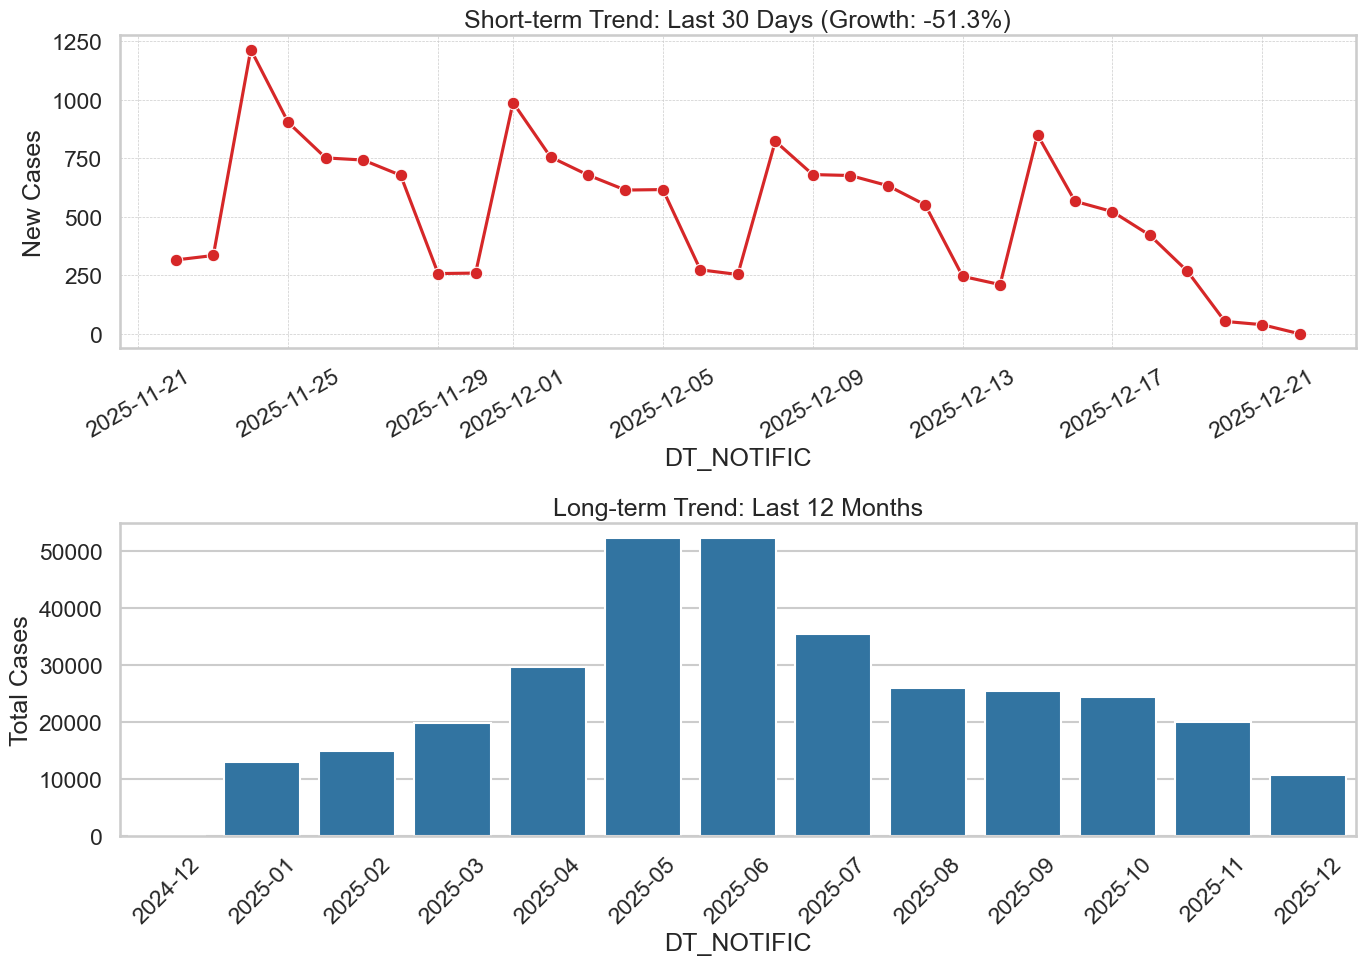

In [9]:
daily_cases = df.set_index('DT_NOTIFIC').resample('D').size().reset_index(name='cases')

last_7d_sum = daily_cases.tail(7)['cases'].sum()
prev_7d_sum = daily_cases.iloc[-14:-7]['cases'].sum()

if prev_7d_sum > 0:
    growth_rate = ((last_7d_sum - prev_7d_sum) / prev_7d_sum) * 100
else:
    growth_rate = 0

print(f"EPIDEMIC TREND (Weekly Rolling Window):")
print(f"   - Cases (Last 7 Days): {last_7d_sum}")
print(f"   - Cases (Previous 7 Days): {prev_7d_sum}")
print(f"   - Growth Rate: {growth_rate:+.2f}%")

max_date = daily_cases['DT_NOTIFIC'].max()
df_30d = daily_cases[daily_cases['DT_NOTIFIC'] >= (max_date - pd.Timedelta(days=30))]

df_12m = df[df['DT_NOTIFIC'] >= (max_date - pd.Timedelta(days=365))].copy()
monthly_cases = df_12m.set_index('DT_NOTIFIC').resample('ME').size().reset_index(name='cases')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

sns.lineplot(data=df_30d, x='DT_NOTIFIC', y='cases', marker='o', color='#d62728', ax=axes[0])
axes[0].set_title(f"Short-term Trend: Last 30 Days (Growth: {growth_rate:+.1f}%)")
axes[0].set_ylabel("New Cases")
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=monthly_cases, x=monthly_cases['DT_NOTIFIC'].dt.strftime('%Y-%m'), y='cases', color='#1f77b4', ax=axes[1])
axes[1].set_title("Long-term Trend: Last 12 Months")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel("Total Cases")

plt.tight_layout()
plt.show()

The visualization validates our rolling window approach.
* **Short-term (30 Days):** The red line chart shows the immediate volatility and current trajectory of the outbreak.
* **Long-term (12 Months):** The blue bar chart provides the seasonality context (e.g., identifying winter peaks vs. current levels).
* **Architecture Decision:** The `plot_tool` will be hardcoded to produce exactly these two views, as they satisfy the the requirement for "scenario explanation" without overwhelming the user with raw data.

## 6. Architecture & Strategy Definition
Based on the EDA findings above, we have validated the critical drivers of severity and data limitations. This defines the final blueprint for the **SRAG Reporting Agent**.

### 1. Database Schema Strategy (DuckDB)
We will implement a curated view `srag_analytics`. Instead of feeding raw data to the LLM, we restrict the schema to the variables strictly necessary to satisfy the business requirements validated in this notebook.

**Schema Traceability Matrix:**

| Source Variable | Business Meaning | Architecture Requirement |
|---|---|---|
| **DT_NOTIFIC** | **Notification Date** | Essential for time series such as "cases in the last 30 days" and "last 12 months". Without a date, there is no trend analysis. |
| **EVOLUCAO** | **Case Outcome** (Cure/Death) | The way to calculate the **Mortality Rate**. |
| **UTI** | **ICU Usage** | Mandatory for the **ICU Occupancy Rate**. Acts as the primary proxy for resource strain severity. |
| **VACINA** | **Flu Vaccination** | **Specific Context.** Required to calculate immunization rates for Influenza cases. |
| **VACINA_COV** | **COVID-19 Vaccination** | **Specific Context.** Required to calculate immunization rates for COVID-19 cases. Critical for distinguishing protection levels against different pathogens. |
| **CLASSI_FIN** | **Final Diagnosis** | **Quality Filter.** Allows the Agent to distinguish between generic Influenza and COVID-19, preventing misleading generalizations. |
| **NU_IDADE_N** | **Age** | **Context Driver.** Validated in Section 3 (Hypothesis A). Essential for explaining mortality demographics (e.g., "Elderly population affected"). |
| **CS_SEXO** | **Sex** | **Demographic Context.** Standard epidemiological requirement for identifying risk groups. |
| **CARDIOPATI** | **Heart Disease** | **Context Driver.** Validated in Section 3 (Hypothesis B). Included to explain mortality clusters in patients with cardiovascular history. |
| **DIABETES** | **Diabetes** | **Context Driver.** Validated in Section 3 (Hypothesis B). Crucial for explaining severity in patients with metabolic disorders. |
| **OBESIDADE** | **Obesity** | **Context Driver.** Validated in Section 3 (Hypothesis B). A key risk factor often correlated with higher ICU admission rates. |

### 2. Agent Guardrails (System Prompt)
The LLM must be instructed with strict constraints based on our data quality audit:
* **Vaccination Disclaimer:** *“Warning: Vaccination rates are calculated based on the hospitalized cohort, not the general population census.”* (Triggered by the high volume of 'Ignored' data).
* **Temporal Grounding:** *“The analysis period ends on {max_date}. Do not hallucinate current-day events beyond this date.”*

### 3. Tool Specifications
* **`stats_tool`:** A SQL-wrapper restricted to aggregation queries (SUM, COUNT, AVG) on the curated schema. It blocks access to PII columns (Names, CPF).
* **`plot_tool`:** Hardcoded to generate the two validated visualizations (30-day Trend & 12-month History) to ensure consistency with the requirements.